Using the CMSW framework, and the hypothesis that informed traders use limit orders (Bloomfield, O'Hara, Saar (2003)), we test the thesis that the risk (std of payoff) is inversely related to order book depth

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from trader import Trader
from order_book import OrderBook

import utilities

from scipy import stats
import statsmodels.api as sm

from tqdm import tqdm


In [2]:
def trader_utility_function_expected_value(alpha, wealth_mean, wealth_std):
    # utility function: U(W) = - exp(- alpha * W)
    # where W is trader's wealth
    # the expectation, given that the Wealth is distributed as N(mu_W, sigma_W):
    return - np.exp(- alpha * wealth_mean + ((alpha * wealth_std)**2)/2)

def compute_wealth_mean_base(trader, payoff_mean):
    return trader.number_units_stock * payoff_mean

def compute_wealth_std_base(trader, payoff_std):
    return trader.number_units_stock * payoff_std


def compute_wealth_mean_buy(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock + quantity) * payoff_mean - (price * quantity)

def compute_wealth_std_buy(trader, payoff_std, quantity):
    return (trader.number_units_stock + quantity) * payoff_std

def compute_wealth_mean_sell(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock - quantity) * payoff_mean + (price * quantity)

def compute_wealth_std_sell(trader, payoff_std, quantity):
    return (trader.number_units_stock - quantity) * payoff_std

def probability_hit_buy(price, mean, std): #lambda_par, theta, price):
    #return 1 - np.exp( - lambda_par * (price - theta) )
    z = (price - mean) / std
    
    return stats.norm.cdf(z)


def trader_utility_function_expected_value_hit(
        trader_base_utility_expectation, 
        trader_limit_utility_expectation, 
        probability_hit_limit_order):
    return (
        probability_hit_limit_order * trader_limit_utility_expectation
        ) + (1 - probability_hit_limit_order) * trader_base_utility_expectation


def generate_random_variable_exponential(lambda_, theta):
    U = np.random.uniform(0, 1)
    
    # invert the cdf f(x) = lambda * exp(- lambda * (x - theta))
    X = theta - (1 / lambda_) * np.log(1 - U)
    
    return X

In [3]:
np.random.seed(700)


initial_wealth = 5

alpha = 1

ticksize = 0.01

In [4]:
def simulate(book, fraction_of_informed_buyers, prob_seller, simulation_length, payoff_mean, payoff_std):
    # initial bids and asks to provide some liquidity
    book.bids = [((payoff_mean - ticksize*1), 10), ((payoff_mean - ticksize*2), 12), ((payoff_mean - ticksize*3), 15), ((payoff_mean - ticksize*4), 20)]
    book.asks = [((payoff_mean + ticksize*1), 10), ((payoff_mean + ticksize*2), 12), ((payoff_mean + ticksize*3), 15), ((payoff_mean + ticksize*4), 20)]
    
    for ii in range(simulation_length):

        rand = np.random.uniform(low=0, high=1)
        quantity = abs(np.random.normal(0, 1))

        if rand < prob_seller:
            # the trader is a seller
            trader = Trader(number_units_stock=quantity)
            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, payoff_mean), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
        
            best_bid = book.bids[0][0]

            # noisy seller       
            sell_price = round(best_bid + abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
            
            expected_payoff = sell_price - abs(np.random.normal(0, payoff_std))

            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
            
            limit_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=sell_price, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            market_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=best_bid, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            # sell prob
            probability_hit_limit_order = 1 - probability_hit_buy(price=sell_price, mean=expected_payoff, std=payoff_std)

            hit_utility = trader_utility_function_expected_value_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order)

            if (hit_utility > market_utility) and (hit_utility > base_utility):
                # limit sell
                trader.submit_order_to_order_book(
                    order_type='limit_sell', 
                    price=sell_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                trader.submit_order_to_order_book(
                    order_type='market_sell', 
                    price=None, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
                
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

        
        else:
            # the trader is a buyer
            rand = np.random.uniform(low=0, high=1)
            
            best_ask = book.asks[0][0]

            if rand < fraction_of_informed_buyers:
                # the trader is informed
                # doesn't want to pay more than the payoff
                buy_price = round(min(payoff_mean - abs(np.random.normal(0, payoff_std)), best_ask), utilities.number_of_decimal_digits(ticksize))
                std = 0
                expected_payoff = payoff_mean
            else:
                # noise trader, trades around the final payoff
                buy_price = round(best_ask - abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
                std = payoff_std
                expected_payoff = buy_price + abs(np.random.normal(0, payoff_std))

            trader = Trader(number_units_stock=0)
            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, std)
                )
            

            limit_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=buy_price, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )
            
            market_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=best_ask, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )

            probability_hit_limit_order = probability_hit_buy(price=buy_price, mean=expected_payoff, std=payoff_std)

            hit_utility = trader_utility_function_expected_value_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order
                )

            if (hit_utility > base_utility) and (hit_utility > market_utility):
                # limit order -> it has a prob of execution
                trader.submit_order_to_order_book(
                    order_type='limit_buy', 
                    price=buy_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
                
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                # market order -> no prob because it will surely be executed
                trader.submit_order_to_order_book(
                    order_type='market_buy', 
                    price=None,
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

        #book.print_order_book_state()
    def sum_blocks(l, size_block):
        sum_block = []
        for i in range(0, len(l), size_block):
            block = l[i:i + size_block]
            sum_b = sum(block)
            sum_block.append(sum_b)
        return sum_block

    aggregate_time = 1

    order_flow_imbalance = sum_blocks(book.order_flow_imbalance_sequence, aggregate_time)

    mid_price_diff = [0, ]
    for i in range(1, len(book.mid_price_sequence)):
        change = (book.mid_price_sequence[i] - book.mid_price_sequence[i-1])
        mid_price_diff.append(change)

    mid_price_diff = sum_blocks(mid_price_diff, aggregate_time)

    return book, order_flow_imbalance, mid_price_diff


  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 490/490 [03:02<00:00,  2.69it/s]


Depth mean: 82.67325533009713
Depth std: 17.664378548526543
Quadratic coefficients: [-219.93158136  200.66144355    3.8077136 ]
linear regression parameters
[13.10445809 92.08313626]


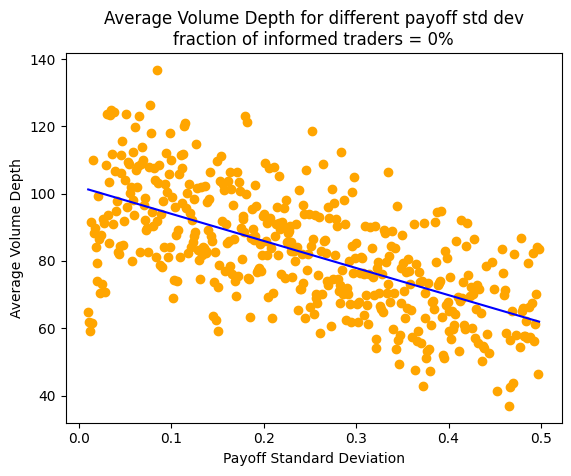

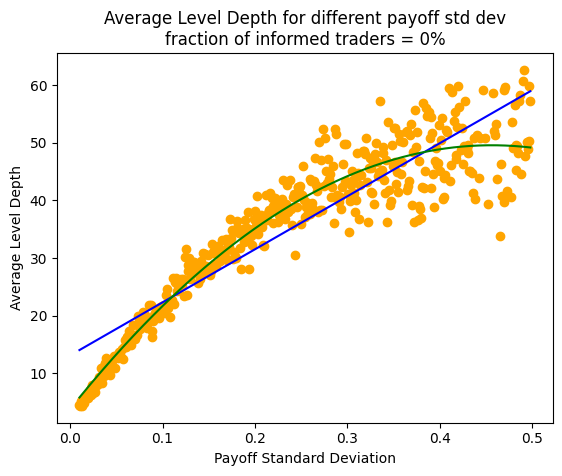

In [5]:
depth_inf_0_size = []
depth_inf_0_volumes = []
simulation_length = 1000

f = 0

for std in tqdm(range(10,500)):
    try:
        s = std/1000
        book, _, _ = simulate(
                        book=OrderBook(), 
                        fraction_of_informed_buyers=f, 
                        prob_seller=0.5, 
                        simulation_length=simulation_length, 
                        payoff_mean=10, 
                        payoff_std=s)

        depth_inf_0_size.append((s, book.depth_sequence_size))
        depth_inf_0_volumes.append((s, book.depth_sequence_volumes))
    except Exception:
        continue


bid_vol = []
f_list = []
for d in depth_inf_0_volumes:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])

x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.xlabel('Payoff Standard Deviation')
plt.ylabel('Average Volume Depth')

plt.title(f'Average Volume Depth for different payoff std dev\nfraction of informed traders = {int(f*100)}%')
plt.scatter(f_list, bid_vol, color='orange')

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')


print(f"Depth mean: {np.mean(bid_vol)}")
print(f"Depth std: {np.std(bid_vol)}")


bid_vol = []
f_list = []
for d in depth_inf_0_size:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])

# with higher payoff std we have more mkt orders (or matching limit orders)
# this is because if the traders expect the price to move a lot, they try to get in (or out) asap
# moreover the level depth increases with the payoff std, since limit orders can have a wider range of prices
# here I fitted a linear regression and a quadratic polynomial. the quadratic fit seems to be more appropriate


x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.scatter(x[:,1], y, color='orange')
plt.xlabel('Payoff Standard Deviation')
plt.ylabel('Average Level Depth')

plt.title(f'Average Level Depth for different payoff std dev\nfraction of informed traders = {int(f*100)}%')

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')

coefficients = np.polyfit(f_list, y, 2)
y_fit = np.polyval(coefficients, f_list)

plt.plot(f_list, y_fit, color='green', label='Quadratic fit')

print("Quadratic coefficients:", coefficients)

print("linear regression parameters")
print(results.params)

100%|██████████| 490/490 [03:03<00:00,  2.67it/s]


Depth mean: 107.8989688817942
Depth std: 20.344327938706193
Quadratic coefficients: [-199.32035656  211.27481301    3.20355446]
linear regression parameters
[ 12.03472913 110.3863985 ]


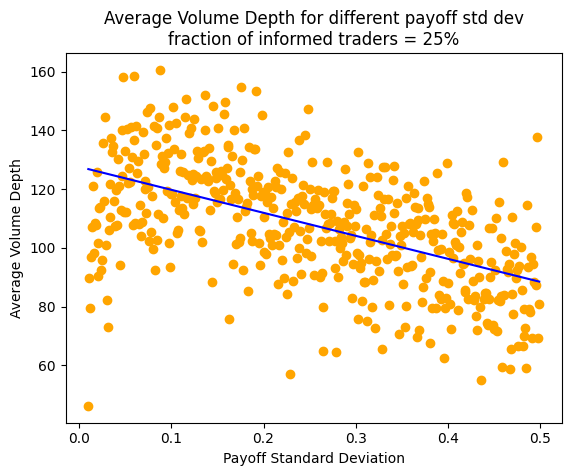

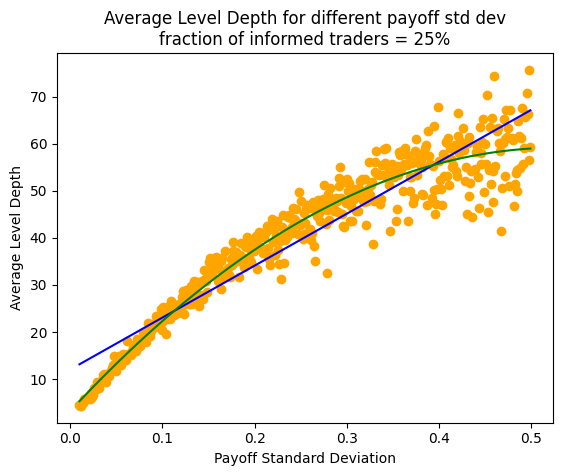

In [6]:
depth_inf_0_size = []
depth_inf_0_volumes = []
simulation_length = 1000

f = 0.25

for std in tqdm(range(10,500)):
    try:
        s = std/1000
        book, _, _ = simulate(
                        book=OrderBook(), 
                        fraction_of_informed_buyers=f, 
                        prob_seller=0.5, 
                        simulation_length=simulation_length, 
                        payoff_mean=10, 
                        payoff_std=s)

        depth_inf_0_size.append((s, book.depth_sequence_size))
        depth_inf_0_volumes.append((s, book.depth_sequence_volumes))
    except Exception:
        continue

# with some informed traders, the average depth is higher since there are less mkt orders

bid_vol = []
f_list = []
for d in depth_inf_0_volumes:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])

x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.scatter(x[:,1], y, color='orange')
plt.xlabel('Payoff Standard Deviation')
plt.ylabel('Average Volume Depth')

plt.title(f'Average Volume Depth for different payoff std dev\nfraction of informed traders = {int(f*100)}%')

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')


print(f"Depth mean: {np.mean(bid_vol)}")
print(f"Depth std: {np.std(bid_vol)}")


bid_vol = []
f_list = []
for d in depth_inf_0_size:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])


x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.scatter(x[:,1], y, color='orange')
plt.xlabel('Payoff Standard Deviation')
plt.ylabel('Average Level Depth')

plt.title(f'Average Level Depth for different payoff std dev\nfraction of informed traders = {int(f*100)}%')

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')

coefficients = np.polyfit(f_list, y, 2)
y_fit = np.polyval(coefficients, f_list)

plt.plot(f_list, y_fit, color='green', label='Quadratic fit')

print("Quadratic coefficients:", coefficients)

print("linear regression parameters")
print(results.params)